# Анализ набора данных изображений российских дорожных знаков (RTSD)

Набор данных RTSD содержит кадры, предоставленные консалтинговой компанией Geocenter (http://geocenter-consulting.ru ). Кадры получены с широкоэкранного цифрового видеомагнитофона, который снимает 5 кадров в секунду. Разрешение кадра составляет от 1280 × 720 до 1920 × 1080. Кадры снимаются в разное время года (весна, осень, зима), в разное время суток (утро, день, вечер) и в разных погодных условиях (дождь, снег, яркое солнце). В наборе используется 155 знак дорожного движения, формат разметки - Common Objects in Context (COCO).

Файлы json состоят из 3 списков:

- images содержит информацию о изображениях (метаданные - id, ширина, высота и путь к файлу);

- annotations содержит информацию о аннотациях (ограничивающие прямоугольники, классы объектов и т.д.);

- categories содержит информацию о категориях классификации.

In [1]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install Cython
# !pip install fiftyone
# !pip install pycocotools

In [4]:
# библиотеки
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
# from pycocotools.coco import COCO
# import fiftyone as fo

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Загрузим набор данных RTSD
with open(os.path.join('.', 'train_anno.json'), 'r') as f:
    train_anno = json.load(f)
train_anno.keys()

dict_keys(['images', 'annotations', 'categories'])

In [6]:
obj1 = train_anno.get('images')
df1 = pd.json_normalize(obj1)
df1

,id,width,height,file_name
0,0,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,1280,720,rtsd-frames/autosave01_02_2012_09_13_37.jpg
...,...,...,...,...
54183,59183,1280,720,rtsd-frames/autosave24_10_2013_13_18_37_1.jpg
54184,59184,1280,720,rtsd-frames/autosave24_10_2013_13_18_37_2.jpg
54185,59185,1280,720,rtsd-frames/autosave24_10_2013_13_18_38_0.jpg
54186,59186,1280,720,rtsd-frames/autosave24_10_2013_13_18_38_1.jpg


In [7]:
obj2 = train_anno.get('annotations')
df2 = pd.json_normalize(obj2)
df2

,id,image_id,category_id,area,bbox,iscrowd
0,0,0,1,324,"[649, 376, 18, 18]",0
1,1,1,1,420,"[671, 356, 20, 21]",0
2,2,2,1,702,"[711, 332, 27, 26]",0
3,3,3,1,1332,"[764, 290, 37, 36]",0
4,4,3,2,289,"[684, 384, 17, 17]",0
...,...,...,...,...,...,...
95487,104353,59183,116,432,"[622, 394, 27, 16]",0
95488,104354,59184,116,558,"[638, 387, 31, 18]",0
95489,104355,59185,116,660,"[647, 385, 33, 20]",0
95490,104356,59186,116,943,"[668, 378, 41, 23]",0


In [8]:
obj3 = train_anno.get('categories')
df3 = pd.json_normalize(obj3)
df3

,id,name
0,1,2_1
1,2,1_23
2,3,1_17
3,4,3_24
4,5,8_2_1
...,...,...
150,151,1_10
151,152,8_16
152,153,7_18
153,154,7_14


In [9]:
t1 = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
t1

,id,image_id,category_id,area,bbox,iscrowd,name
0,0,0,1,324,"[649, 376, 18, 18]",0,2_1
1,1,1,1,420,"[671, 356, 20, 21]",0,2_1
2,2,2,1,702,"[711, 332, 27, 26]",0,2_1
3,3,3,1,1332,"[764, 290, 37, 36]",0,2_1
5,5,4,1,3192,"[876, 200, 56, 57]",0,2_1
...,...,...,...,...,...,...,...
93566,102243,57701,154,2340,"[767, 306, 39, 60]",0,7_14
93567,102245,57703,154,16912,"[1143, 101, 112, 151]",0,7_14
93720,102416,57822,155,612,"[762, 367, 36, 17]",0,8_23
93723,102419,57823,155,1456,"[878, 346, 56, 26]",0,8_23


In [10]:
t2= t1.merge(df1.set_index('id'), left_on='image_id',right_index=True)
t2

,id,image_id,category_id,area,bbox,iscrowd,name,width,height,file_name
0,0,0,1,324,"[649, 376, 18, 18]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_33.jpg
1,1,1,1,420,"[671, 356, 20, 21]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_34.jpg
2,2,2,1,702,"[711, 332, 27, 26]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_35.jpg
3,3,3,1,1332,"[764, 290, 37, 36]",0,2_1,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
4,4,3,2,289,"[684, 384, 17, 17]",0,1_23,1280,720,rtsd-frames/autosave01_02_2012_09_13_36.jpg
...,...,...,...,...,...,...,...,...,...,...
64600,70506,38149,149,2100,"[1007, 307, 35, 60]",0,6_8_1,1280,720,rtsd-frames/autosave16_10_2012_08_36_42_2.jpg
64601,70507,38150,149,3150,"[1088, 296, 45, 70]",0,6_8_1,1280,720,rtsd-frames/autosave16_10_2012_08_36_43_0.jpg
93565,102242,57700,154,1519,"[712, 329, 31, 49]",0,7_14,1280,720,rtsd-frames/autosave24_10_2013_11_23_19_1.jpg
93566,102243,57701,154,2340,"[767, 306, 39, 60]",0,7_14,1280,720,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg


In [11]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [12]:
df_train_anno = dataset('.', 'train_anno.json')

In [13]:
# посмотрим инфо по датасету
df_train_anno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95492 entries, 0 to 93567
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           95492 non-null  int64 
 1   image_id     95492 non-null  int64 
 2   category_id  95492 non-null  int64 
 3   area         95492 non-null  int64 
 4   bbox         95492 non-null  object
 5   iscrowd      95492 non-null  int64 
 6   name         95492 non-null  object
 7   width        95492 non-null  int64 
 8   height       95492 non-null  int64 
 9   file_name    95492 non-null  object
dtypes: int64(7), object(3)
memory usage: 8.0+ MB


In [14]:
pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()

,index,name
0,5_19_1,22147
1,2_1,10027
2,5_16,4727
3,5_15_2,4504
4,3_24,3761
...,...,...
150,8_23,3
151,8_3_3,2
152,4_5,2
153,3_33,1


In [15]:
df_train_anno.groupby('file_name', as_index=False).agg(list)

,file_name,id,image_id,category_id,area,bbox,iscrowd,name,width,height
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,[0],[0],[1],[324],"[[649, 376, 18, 18]]",[0],[2_1],[1280],[720]
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,[1],[1],[1],[420],"[[671, 356, 20, 21]]",[0],[2_1],[1280],[720]
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,[2],[2],[1],[702],"[[711, 332, 27, 26]]",[0],[2_1],[1280],[720]
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,"[3, 4]","[3, 3]","[1, 2]","[1332, 289]","[[764, 290, 37, 36], [684, 384, 17, 17]]","[0, 0]","[2_1, 1_23]","[1280, 1280]","[720, 720]"
4,rtsd-frames/autosave01_02_2012_09_13_37.jpg,"[5, 6]","[4, 4]","[1, 2]","[3192, 462]","[[876, 200, 56, 57], [705, 377, 22, 21]]","[0, 0]","[2_1, 1_23]","[1280, 1280]","[720, 720]"
...,...,...,...,...,...,...,...,...,...,...
54183,rtsd-frames/autosave24_10_2013_13_18_37_1.jpg,[104353],[59183],[116],[432],"[[622, 394, 27, 16]]",[0],[5_15_7],[1280],[720]
54184,rtsd-frames/autosave24_10_2013_13_18_37_2.jpg,[104354],[59184],[116],[558],"[[638, 387, 31, 18]]",[0],[5_15_7],[1280],[720]
54185,rtsd-frames/autosave24_10_2013_13_18_38_0.jpg,[104355],[59185],[116],[660],"[[647, 385, 33, 20]]",[0],[5_15_7],[1280],[720]
54186,rtsd-frames/autosave24_10_2013_13_18_38_1.jpg,[104356],[59186],[116],[943],"[[668, 378, 41, 23]]",[0],[5_15_7],[1280],[720]


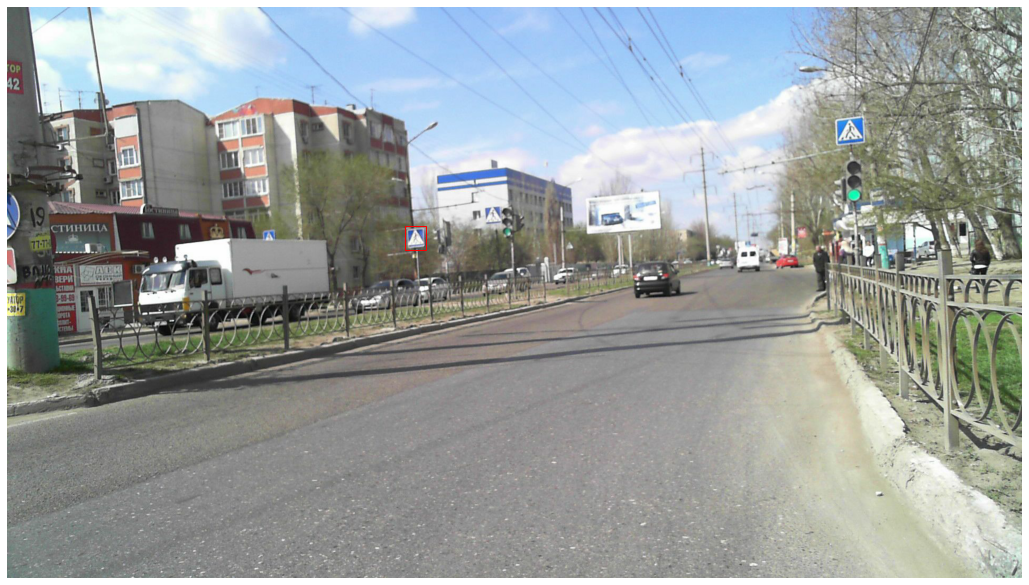

In [16]:
# посмотрим фото
df_train_anno
y = np.random.choice(df_train_anno.file_name)

im_labels = df_train_anno[df_train_anno.file_name == y].iloc[0]

im = Image.open('./' + y)
# Create figure and axes
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.axis('off')
plt.show()

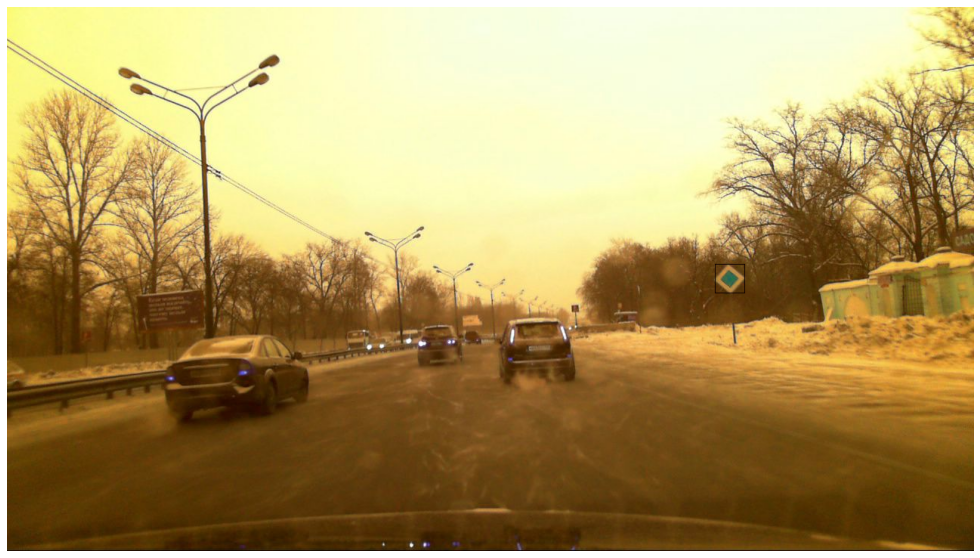

In [17]:
fig = plt.figure(figsize=(18, 10))
r3 = np.random.choice(df_train_anno.file_name)
q = cv2.imread('./' + r3, 1)
im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]

plt.imshow(q)

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)

plt.imshow(rect)
plt.axis("off")
plt.show() 

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)

plt.imshow(rect)
plt.axis("off")
plt.show() 

<Figure size 720x576 with 0 Axes>

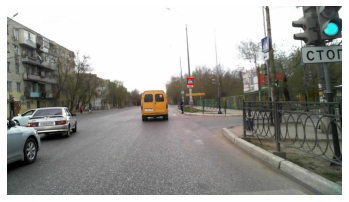

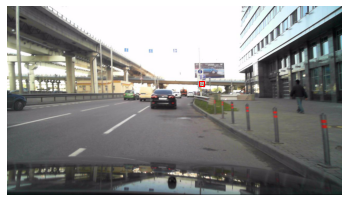

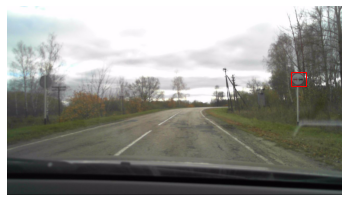

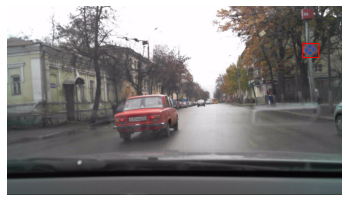

In [18]:
figure = plt.figure(figsize=(10, 8))
for i in range(1, 5):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    im = Image.open('./' + r)
    fig, ax = plt.subplots()
    ax.imshow(im)
    rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
plt.show()

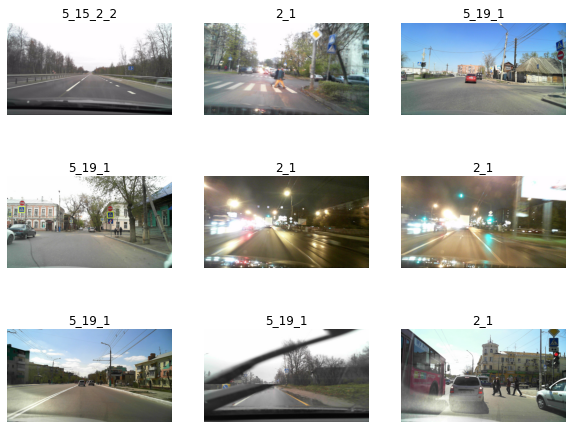

In [19]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r].iloc[0]['name']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(im)
    rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

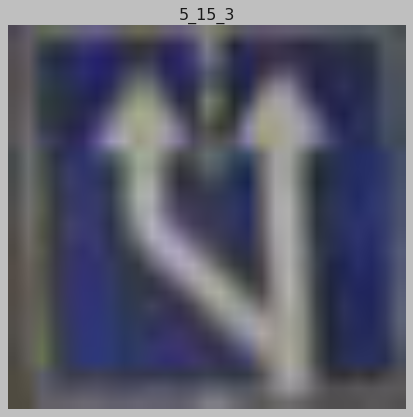

In [51]:
# посмотрим знаки
y = np.random.choice(df_train_anno.file_name)
im_labels = df_train_anno[df_train_anno.file_name == y].iloc[0]
im = Image.open('./' + y)
label = df_train_anno[df_train_anno.file_name == y].iloc[0]['name']
coordinates = [im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]]
# cropped = im.crop([im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]])
cropped = im.crop(coordinates)
plt.imshow(cropped)
plt.title(label)
plt.axis('off')
plt.show()

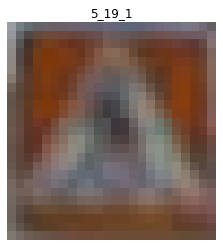

In [21]:
r3 = np.random.choice(df_train_anno.file_name)

im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]
label = df_train_anno[df_train_anno.file_name == r3].iloc[0]['name']

q = cv2.imread('./' + r3, 1)

cropped = q[im_labels.bbox[1]:im_labels.bbox[1]+im_labels.bbox[3], im_labels.bbox[0]:im_labels.bbox[0]+im_labels.bbox[2]]

plt.imshow(cropped)
plt.title(label)
plt.axis('off')
plt.show()


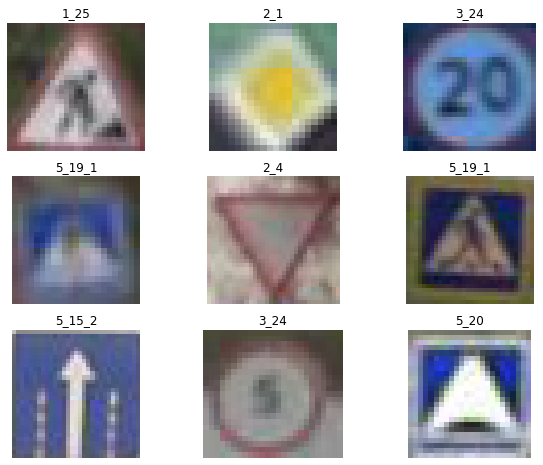

In [22]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r].iloc[0]['name']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    coordinates = ((im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]))
    cropped = im.crop(coordinates)
    plt.imshow(cropped)
    plt.title(label)
    plt.axis("off")
plt.show()

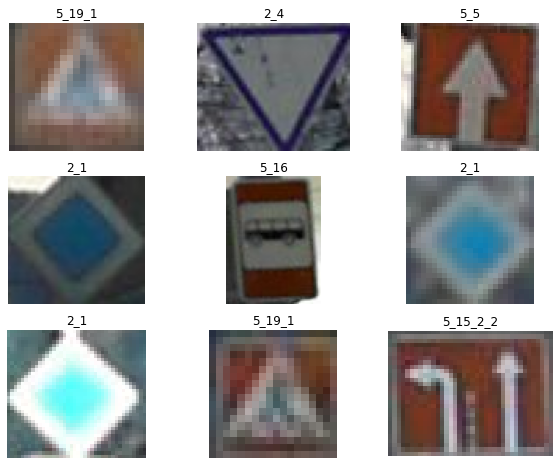

In [23]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r3 = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r3].iloc[0]['name']
    q = cv2.imread('./' + r3, 1)
    figure.add_subplot(rows, cols, i)
    cropped = q[im_labels.bbox[1]:im_labels.bbox[1]+im_labels.bbox[3], im_labels.bbox[0]:im_labels.bbox[0]+im_labels.bbox[2]]
    plt.imshow(cropped)
    plt.title(label)
    plt.axis('off')
plt.show()

In [24]:
# data = fo.Dataset.from_dir(
#         dataset_type=fo.types.COCODetectionDataset,
#         data_path='./',
#         labels_path='train_anno_reduced.json',
#         max_samples=10,
#         shuffle=True,
#         seed=51,
#     )
# session = fo.launch_app(data)

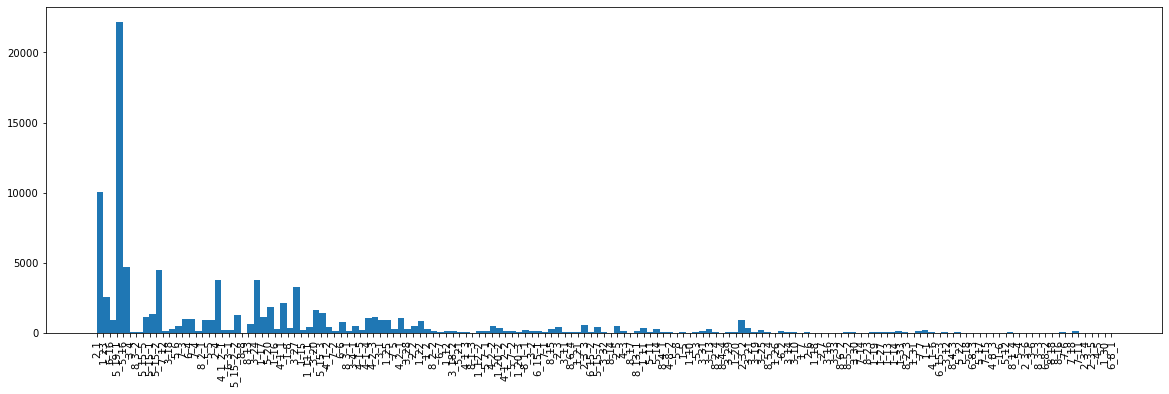

In [25]:
# посмотрим распределение дорожных знаков в датасете train
figure = plt.figure(figsize=(20, 6))
plt.hist(df_train_anno['name'], bins=155)
plt.xticks(rotation=90)
plt.show()

In [26]:
ttt = pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()
ttt.columns = ['category_id', 'name']
ttt

,category_id,name
0,5_19_1,22147
1,2_1,10027
2,5_16,4727
3,5_15_2,4504
4,3_24,3761
...,...,...
150,8_23,3
151,8_3_3,2
152,4_5,2
153,3_33,1


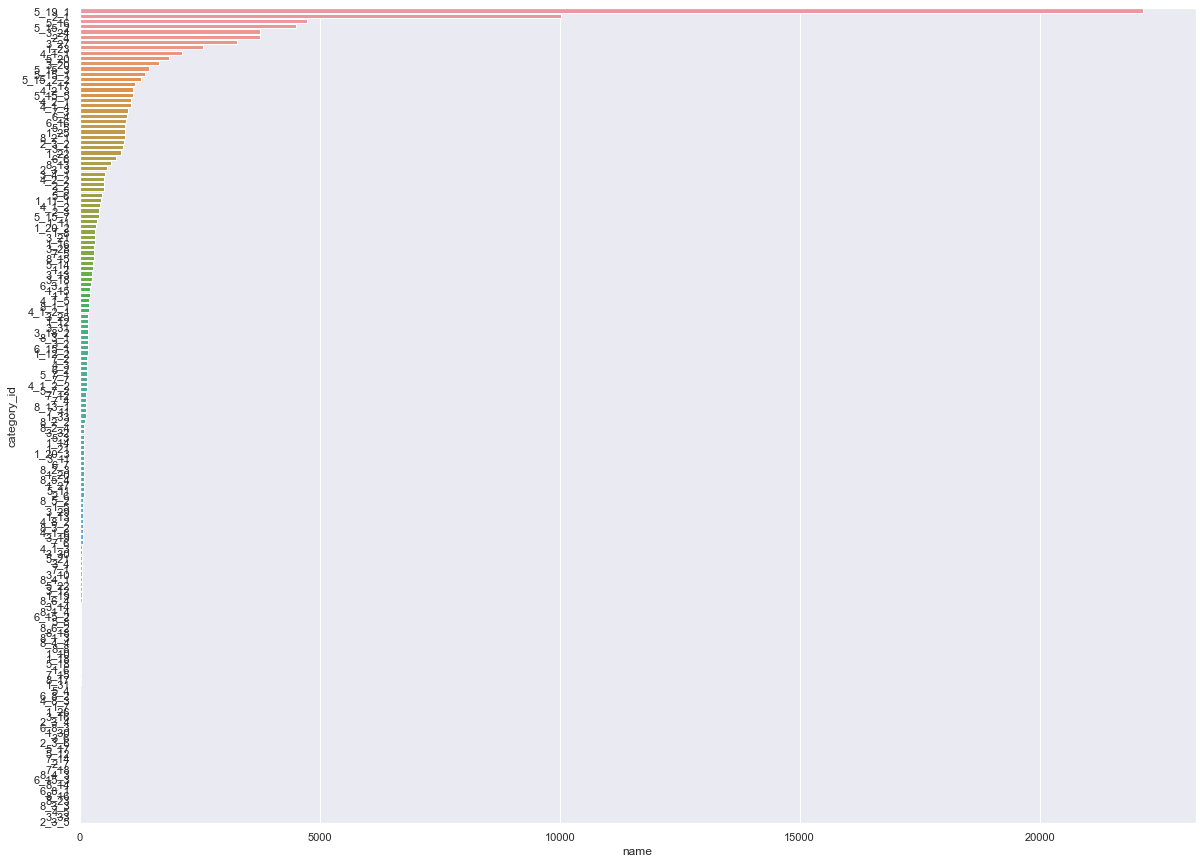

In [27]:
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(data=ttt, x='name', y="category_id")
plt.show()

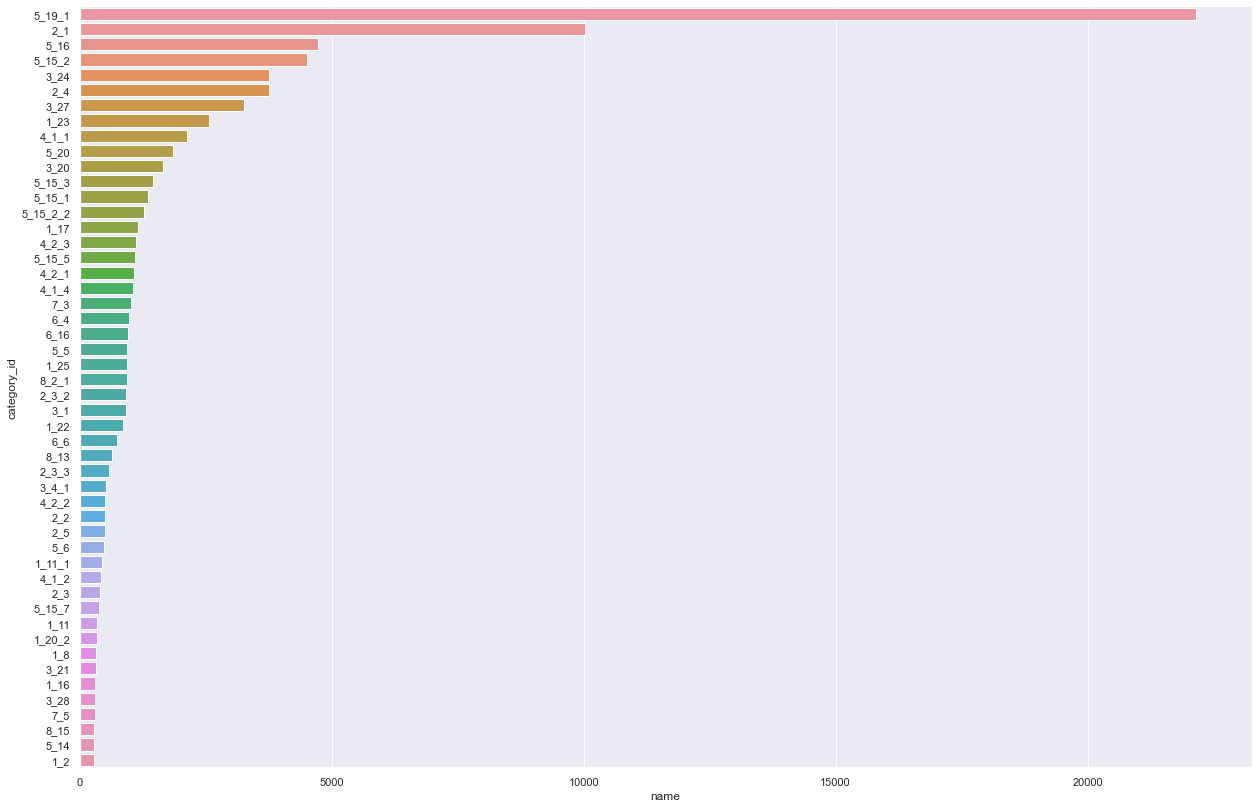

In [28]:
sns.set(rc={'figure.figsize':(21,14)})
sns.barplot(data=ttt[:50], x='name', y="category_id")
plt.show()

In [29]:
# посмотрим распределение дорожных знаков в датасете val
df_val_anno = dataset('.', 'val_anno.json')
df_val_anno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8866 entries, 0 to 8436
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8866 non-null   int64 
 1   image_id     8866 non-null   int64 
 2   category_id  8866 non-null   int64 
 3   area         8866 non-null   int64 
 4   bbox         8866 non-null   object
 5   iscrowd      8866 non-null   int64 
 6   name         8866 non-null   object
 7   width        8866 non-null   int64 
 8   height       8866 non-null   int64 
 9   file_name    8866 non-null   object
dtypes: int64(7), object(3)
memory usage: 761.9+ KB


In [30]:
df_val_anno['name'].value_counts()

5_19_1    2117
2_1        934
5_16       445
5_15_2     440
3_24       343
          ... 
1_26         1
7_18         1
2_7          1
5_12         1
6_8_1        1
Name: name, Length: 139, dtype: int64

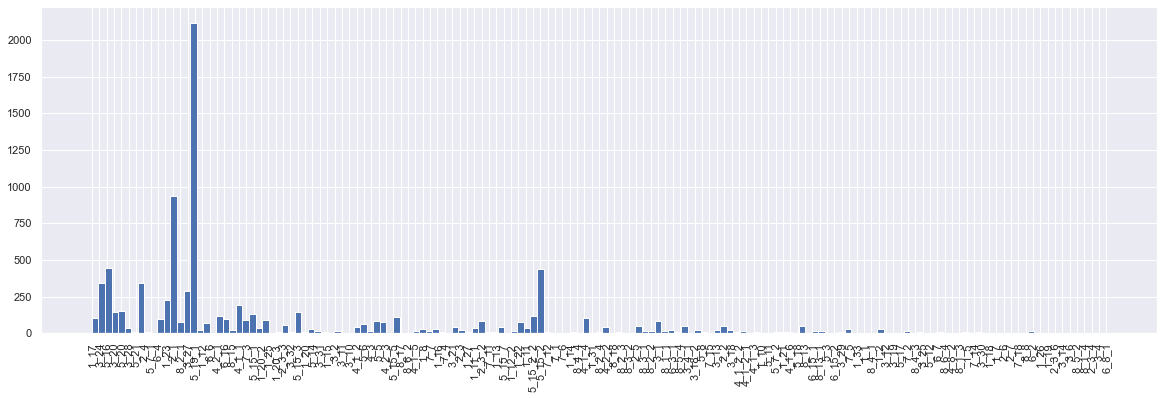

In [31]:
figure = plt.figure(figsize=(20, 6))
plt.hist(df_val_anno['name'], bins=155)
plt.xticks(rotation=90)
plt.show()

In [32]:
# посмотрим распределение дорожных знаков в датасете train_reduced
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')
df_train_anno_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2325 non-null   int64 
 1   image_id     2325 non-null   int64 
 2   category_id  2325 non-null   int64 
 3   area         2325 non-null   int64 
 4   bbox         2325 non-null   object
 5   iscrowd      2325 non-null   int64 
 6   name         2325 non-null   object
 7   width        2325 non-null   int64 
 8   height       2325 non-null   int64 
 9   file_name    2325 non-null   object
dtypes: int64(7), object(3)
memory usage: 199.8+ KB


In [33]:
df_train_anno_reduced['name'].value_counts()

2_1       15
3_10      15
4_1_4     15
8_5_4     15
4_1_5     15
          ..
1_16      15
1_11_1    15
6_6       15
8_5_2     15
8_23      15
Name: name, Length: 155, dtype: int64

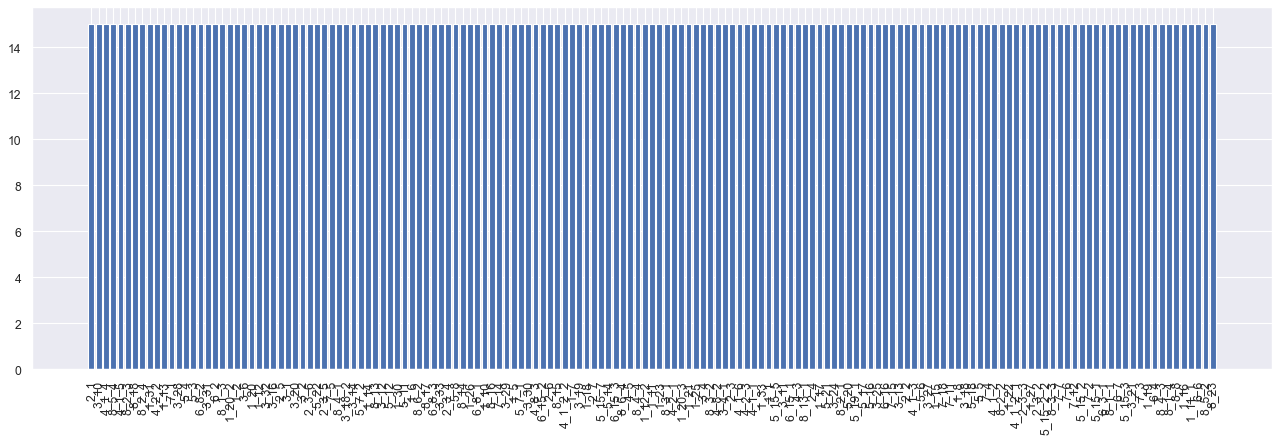

In [34]:
tt = pd.DataFrame(df_train_anno_reduced['name'].value_counts())
figure = plt.figure(figsize=(20, 6), dpi=80)
plt.bar(tt.index, tt.name)
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x432 with 0 Axes>

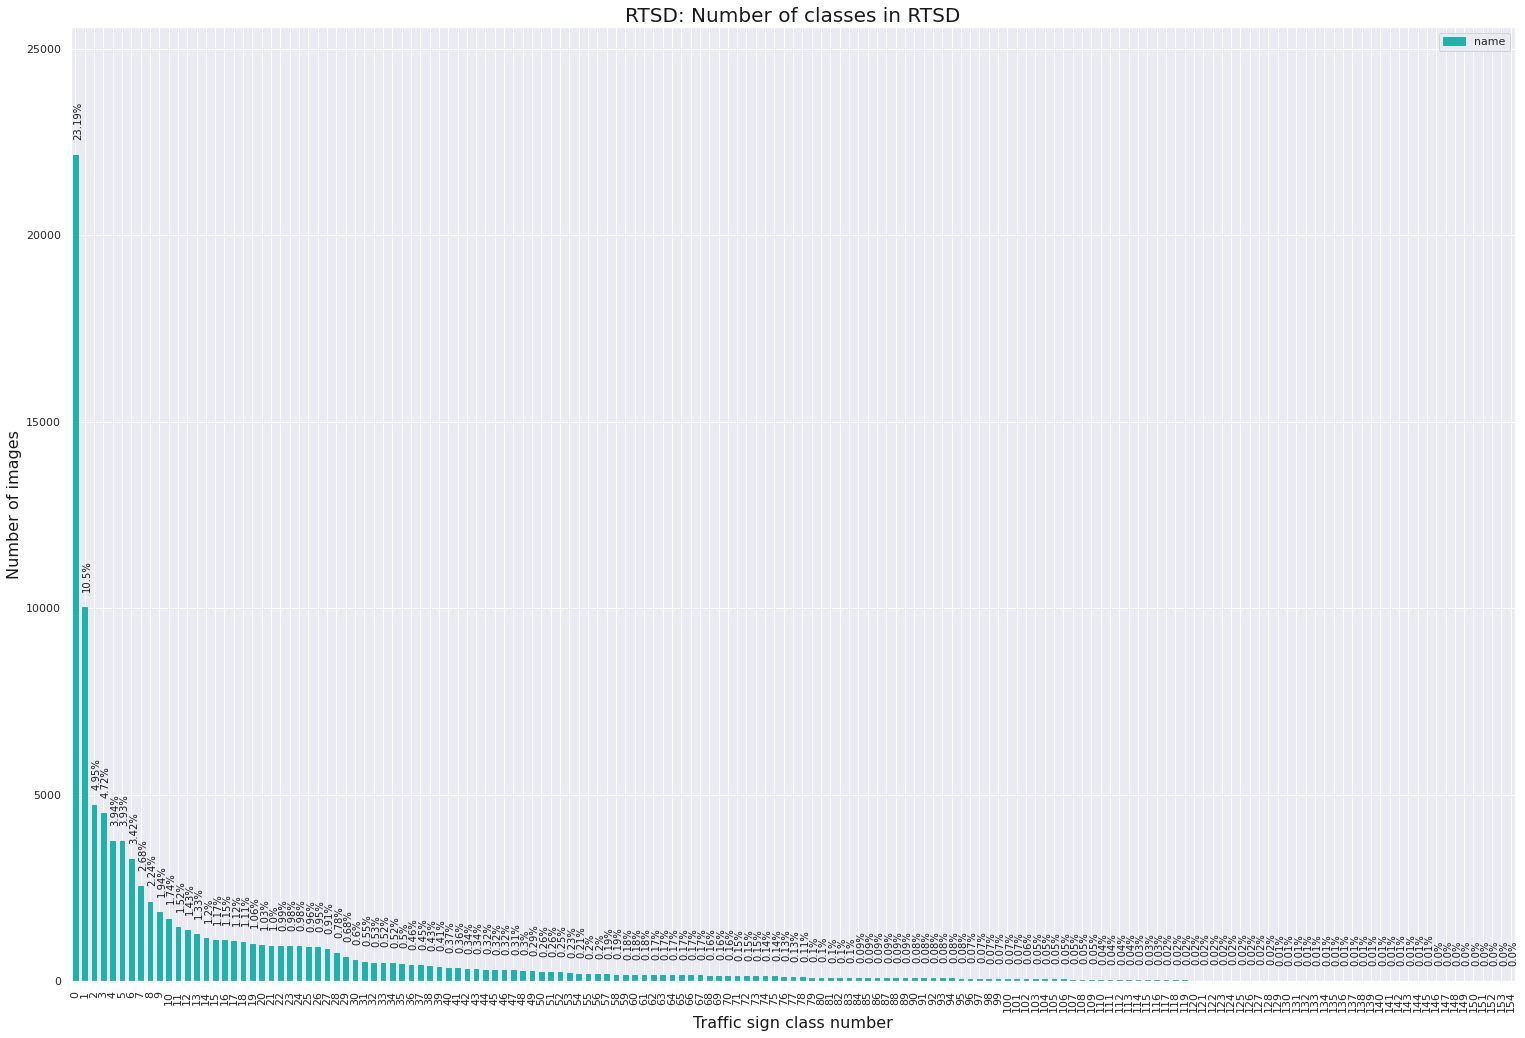

In [35]:
t = pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()
t = t.drop(['index'],axis=1)

fig = plt.figure(figsize=(20, 6))

bars = t.plot.bar(color='lightseagreen', edgecolor='lightseagreen')

plt.tight_layout()
plt.style.use(['classic'])
fig.set_facecolor('w')

totals = []
for bar in bars.patches:
        totals.append(bar.get_height())
total = sum(totals)

ymin, ymax = bars.get_ylim()
bars.set_ylim(top=ymax*1.1)

for bar in bars.patches:
        bar_height = bar.get_height()
        plt.text(bar.get_x(), bar_height + ymax*0.02,
                str(round((bar_height/total)*100, 2)) + "%",
                fontsize=10, rotation=90)

plt.title('RTSD: Number of classes in RTSD', color='k', fontsize=20)
plt.xlabel('Traffic sign class number', color='k', fontsize=16)
plt.ylabel('Number of images', color='k', fontsize=16)
plt.show()

In [36]:
t

,name
0,22147
1,10027
2,4727
3,4504
4,3761
...,...
150,3
151,2
152,2
153,1


In [37]:
# посмотрим наименование/обозначения дорожных знаков
with open(os.path.join('.', 'label_map.json'), 'r') as f:
    label_map = json.load(f)
df_label_map = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
df_label_map.columns = ['name', 'category_id']
df_label_map

,name,category_id
0,2_1,1
1,1_23,2
2,1_17,3
3,3_24,4
4,8_2_1,5
...,...,...
150,1_10,151
151,8_16,152
152,7_18,153
153,7_14,154


In [38]:
df5 = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
df5.columns = ['name', 'category_id']
df5

,name,category_id
0,2_1,1
1,1_23,2
2,1_17,3
3,3_24,4
4,8_2_1,5
...,...,...
150,1_10,151
151,8_16,152
152,7_18,153
153,7_14,154


In [39]:
# Приведем все знаки к одному классу
df_train_anno_1 = df_train_anno.copy()
df_train_anno_1['category_id'] = 1

df_val_anno_1 = df_val_anno.copy()
df_val_anno_1['category_id'] = 1

df_train_anno_reduced_1 = df_train_anno_reduced.copy()
df_train_anno_reduced_1['category_id'] = 1

In [40]:
# разделим df_train_anno на train / test
df_test = df_train_anno.sample(frac = 0.2)
df_train = df_train_anno.drop(df_test.index)
 
print("\n20% of the given DataFrame:")
print(df_test)
 
print("\nrest 80% of the given DataFrame:")
print(df_train)


20% of the given DataFrame:
          id  image_id  category_id  area                 bbox  iscrowd  \
55128  60238     32897            7  1023   [595, 809, 33, 31]        0   
68293  74522     40409           69   529   [822, 226, 23, 23]        0   
15063  16390     10022           26  1023   [789, 303, 33, 31]        0   
84533  92335     51104          124  1480   [915, 346, 40, 37]        0   
86421  94399     52618           66  1131   [853, 323, 39, 29]        0   
...      ...       ...          ...   ...                  ...      ...   
86911  94960     52969            7   399   [434, 356, 21, 19]        0   
16410  17829     10801          123   702   [998, 302, 26, 27]        0   
36536  39915     24278          129   646  [1273, 416, 38, 17]        0   
63073  68870     37232            4  1332   [667, 262, 37, 36]        0   
16530  17961     10887            1   675   [561, 290, 25, 27]        0   

         name  width  height                                      file

In [41]:
def anno_1_class(anno_file):
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    
    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'rtsd'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    
    return anno_json

# train_anno_1 = anno_1_class('train_anno.json')
# val_anno_1 = anno_1_class('val_anno.json')
# train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [42]:
def anno_train_test_split(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as file1:
        anno_json1 = json.load(file1)
    
    x1 = int(len(anno_json1['images'])*0.2)
    file_train = anno_file.split('.')[0] + '_train.json'
          
    del anno_json1['images'][:x1]
    
    with open(os.path.join('.', file_train), 'w') as f1:
                        json.dump(anno_json1, f1)
    
    
    with open(os.path.join('.', anno_file), 'r') as file2:
            anno_json2 = json.load(file2)
    
    
    x2 = int(len(anno_json2['images'])*0.2)
    y2 = int(len(anno_json2['images']))
    
    file_test= anno_file.split('.')[0] + '_test.json'
    
    del anno_json2['images'][x2:y2]
            
    with open(os.path.join('.', file_test), 'w') as f2:
                        json.dump(anno_json2, f2)  
            

    return anno_json1, anno_json2

In [43]:
train1, test1 = anno_train_test_split('train_anno_1.json')

In [44]:
with open(os.path.join('.', 'train_anno_1_test.json'), 'r') as file1:
        anno_json1 = json.load(file1)
        
with open(os.path.join('.', 'train_anno_1_train.json'), 'r') as file2:
        anno_json2 = json.load(file2)
        
with open(os.path.join('.', 'train_anno_1.json'), 'r') as file3:
        anno_json3 = json.load(file3)
        
len(anno_json1['images']), len(anno_json2['images']), len(anno_json3['images']),(len(anno_json1['images'])+len(anno_json2['images']))

(10837, 43351, 54188, 54188)

In [45]:
dataset('.', 'train_anno_reduced_test.json')

,id,image_id,category_id,area,bbox,iscrowd,name,width,height,file_name
0,31193,18983,1,1023,"[754, 390, 31, 33]",0,2_1,1280,720,rtsd-frames/autosave10_10_2012_09_56_26_0.jpg
1,61999,33712,1,13800,"[1827, 162, 92, 150]",0,2_1,1920,1080,rtsd-frames/autosave16_04_2013_14_36_03_2.jpg
2,88705,48608,1,7776,"[1148, 175, 96, 81]",0,2_1,1280,720,rtsd-frames/autosave23_10_2012_10_24_19_1.jpg
3,76908,41763,1,1764,"[735, 168, 42, 42]",0,2_1,1280,720,rtsd-frames/autosave16_10_2012_11_40_34_3.jpg
4,27687,16927,1,868,"[808, 324, 31, 28]",0,2_1,1280,720,rtsd-frames/autosave10_10_2012_08_30_37_2.jpg
...,...,...,...,...,...,...,...,...,...,...
460,561,358,31,2912,"[1220, 282, 56, 52]",0,6_7,1280,720,rtsd-frames/autosave01_02_2012_09_31_22.jpg
461,85627,46559,31,576,"[1065, 385, 24, 24]",0,6_7,1280,720,rtsd-frames/autosave23_10_2012_09_38_28_1.jpg
462,562,359,31,2912,"[1220, 282, 56, 52]",0,6_7,1280,720,rtsd-frames/autosave01_02_2012_09_31_23.jpg
463,85599,46534,31,400,"[960, 355, 20, 20]",0,6_7,1280,720,rtsd-frames/autosave23_10_2012_09_38_01_0.jpg


# Названия знаков

https://www.drom.ru/pdd/pdd/signs/

name     название знака                   category_id

1_1 : Железнодорожный переезд со шлагбаумом : 119
    
1_2 : Железнодорожный переезд без шлагбаума : 80
    
1_5 : Пересечение с трамвайной линией : 130
    
1_6 : Пересечение равнозначных дорог : 137
    
1_7 : Пересечение с круговым движением  : 111
    
1_8 : Светофорное регулирование : 56
    
1_10 : Выезд на набережную : 151
    
1_11 : Опасный поворот (направо) : 62
    
1_11_1 : Опасный поворот (налево) : 39
    
1_12 : Опасные повороты (первый направо) : 66
    
1_12_2 : Опасные повороты (первый налево) : 64
    
1_13 : Крутой спуск : 103
    
1_14 : Крутой подъём : 104
    
1_15 : Скользкая дорога : 27
    
1_16 : Неровная дорога : 38
    
1_17 : Искусственная неровность : 3
    
1_18 : Выброс гравия : 113
    
1_19 : Опасная обочина : 34
    
1_20 : Сужение дороги (с обеих сторон) : 65
    
1_20_2:  Сужение дороги (с правой стороны) : 81
    
1_20_3 : Сужение дороги (с левой стороны) : 16
    
1_21 : Двустороннее движение : 101
    
1_22 : Пешеходный переход : 52
    
1_23 : Дети : 2
    
1_25 : Дорожные работы : 17
    
1_26 : Перегон скота : 147
    
1_27 : Дикие животные : 53
    
1_30 : Низколетящие самолёты : 135
    
1_31: Тоннель : 90
    
1_33 : Прочие опасности : 24
    
2_1 : Главная дорога : 1
    
2_2 : Конец главной дороги : 12
    
2_3 : Пересечение со второстепенной дорогой : 58
    
2_3_2 : Примыкание второстепенной дороги (справа) : 54
    
2_3_3 : Примыкание второстепенной дороги (слева) : 60
    
2_3_4 : Примыкание второстепенной дороги (справа) : 105
    
2_3_5 : Примыкание второстепенной дороги (слева) : 76
    
2_3_6 : Примыкание второстепенной дороги (справа) : 73
    
2_4 : Уступите дорогу : 13
    
2_5 : Движение без остановки запрещено : 68
    
2_6 : Преимущество встречного движения : 108
    
2_7 : Преимущество перед встречным движением : 114
    
3_1 : Въезд запрещён : 69
    
3_2 : Движение запрещено : 72
    
3_4 : Движение грузовых автомобилей запрещено (более указанной массы) : 18
    
3_4_1 : Движение грузовых автомобилей запрещено (более 3,5 т) :20
    
3_6 : Движение тракторов запрещено : 146
    
3_10 : Движение пешеходов запрещено : 91
    
3_11 : Ограничение массы : 124
    
3_12 : Ограничение массы, приходящейся на ось транспортного средства : 140
    
3_13 : Ограничение высоты : 57
    
3_14 : Ограничение ширины : 79
    
3_16 : Ограничение минимальной дистанции : 134
    
3_18 : Поворот направо запрещён : 45
    
3_18_2 : Поворот налево запрещён : 109
    
3_19 : Разворот запрещён : 112
    
3_20 : Обгон запрещён : 71
    
3_21 : Конец зоны запрещения обгона : 102
    
3_24 : Ограничение максимальной скорости : 4
    
3_25:  Конец зоны ограничения максимальной скорости : 9
    
3_27 : Остановка запрещена : 26
    
3_28 : Стоянка запрещена : 94
    
3_29 : Стоянка запрещена по нечётным числам месяца : 131
    
3_30 : Стоянка запрещена по чётным числам месяца : 127
    
3_31 : Конец зоны всех ограничений : 99
    
3_32 : Движение транспортных средств с опасными грузами запрещено : 67
    
3_33 : Движение транспортных средств с взрывчатыми и легковоспламеняющимися грузами запрещено : 141
    
4_1_1 : Движение прямо : 23
    
4_1_2 : Движение направо : 49
    
4_1_2_1 : Движение направо (прямая стрелка) : 28
    
4_1_2_2: Движение налево (прямая стрелка) : 110
    
4_1_3 : Движение налево : 95 
    
4_1_4 : Движение прямо или направо : 82
    
4_1_5 : Движение прямо или налево : 87 
    
4_1_6 : Движение направо или налево : 21
    
4_2_1 : Объезд препятствия справа : 15
    
4_2_2 : Объезд препятствия слева : 92
    
4_2_3 : Объезд препятствия справа или слева : 22
    
4_3 : Круговое движение : 86
    
4_5 : Пешеходная дорожка : 123
    
4_8_2 : Направление движения транспортных средств с опасными грузами (направо) : 70
    
4_8_3 : Направление движения транспортных средств с опасными грузами (налево) : 106
    
5_3 : Дорога для автомобилей : 97
    
5_4 : Конец дороги для автомобилей : 96
    
5_5 : Дорога с односторонним движением : 47
    
5_6 : Конец дороги с односторонним движением : 46
    
5_7_1 : Выезд на дорогу с односторонним движением (направо) : 128
    
5_7_2 : Выезд на дорогу с односторонним движением (налево) : 129
    
5_8 : Реверсивное движение : 143
    
5_11 : Дорога с полосой для маршрутных транспортных средств : 136
    
5_12 : Конец дороги с полосой для маршрутных транспортных средств : 133
    
5_14 : Полоса для маршрутных транспортных средств : 117
    
5_15_1 : Направления движения по полосам : 41
    
5_15_2 : Направления движения по полосе : 43
    
5_15_2_2 : Направления движения по полосе (в 2 полосы) : 55
    
5_15_3 : Начало полосы : 32
    
5_15_5 : Конец полосы : 25
    
5_15_7 : Направление движения по полосе : 116
    
5_16 : Место остановки автобуса и(или) троллейбуса : 8
    
5_17 : Место остановки трамвая : 150
    
5_18 : Место стоянки легковых такси : 75
    
5_19_1 : Пешеходный переход : 7
    
5_20 : Искусственная неровность : 6
    
5_21 : Жилая зона : 118
    
5_22 : Конец жилой зоны : 74
    
6_2 : Рекомендуемая скорость : 100
    
6_3_1 : Место для разворота : 29
    
6_4 : Парковка (парковочное место) : 35
    
6_6 : Подземный пешеходный переход : 40
    
6_7 : Надземный пешеходный переход : 31
    
6_8_1 : Тупик (прямо) : 149
    
6_8_2 : Тупик (направо) : 98
    
6_8_3 : Тупик (налево) 139
    
6_15_1 : Направление движения для грузовых автомобилей (прямо) : 120
    
6_15_2 : Направление движения для грузовых автомобилей (направо) : 107
    
6_15_3 : Направление движения для грузовых автомобилей (налево) : 132
    
6_16 : Стоп-линия : 10
    
7_1 : Пункт первой медицинской помощи : 93
    
7_2 : Больница : 42
    
7_3 : Автозаправочная станция : 33
    
7_4 : Техническое обслуживание автомобилей : 48
    
7_5 : Мойка автомобилей : 77
    
7_6 : Телефон : 83
    
7_7 : Пункт питания : 61
    
7_11 : Место отдыха : 51
    
7_12 : Пост ДПС : 44
    
7_14 : Пункт транспортного контроля : 154
    
7_15 : Зона приёма радиостанции, передающей информацию о дорожном движении : 11
    
7_18 : Туалет : 153
    
8_1_1 : Расстояние до объекта : 30
    
8_1_3 : Расстояние до объекта (в стороне от дороги справа) : 84
    
8_1_4 : Расстояние до объекта (в стороне от дороги слева) : 36
    
8_2_1 : Зона действия (протяженность) : 5
    
8_2_2 : Зона действия : 50
    
8_2_3 : Зона действия (конец зоны действия) : 88
    
8_2_4 : Зона действия (нахождение в зоне действия) : 89
    
8_3_1 : Направления действия (направо) : 85
    
8_3_2 : Направления действия (налево) : 19
    
8_3_3 : Направления действия (направо и налево) : 59
    
8_4_1 : Вид транспортного средства (грузовой автомобиль более 3,5 т) : 78
    
8_4_3 : Вид транспортного средства (легковой автомобиль) : 142
    
8_4_4 : Вид транспортного средства (автобус) : 126
    
8_5_2 : Рабочие дни : 148
    
8_5_4 : Время действия : 115
    
8_6_2 : Способ постановки транспортного средства на стоянку (в заездом на обочину) : 138
    
8_6_4 : Способ постановки транспортного средства на стоянку (перпендикулярно обочине) : 121
    
8_8 : Платные услуги : 37
    
8_13 : Направление главной дороги : 63
    
8_13_1 : Направление главной дороги (кольцо) : 14
    
8_14 : Полоса движения : 144
    
8_15 : Слепые пешеходы : 122
    
8_16 : Влажное покрытие : 152
    
8_17 : Инвалиды : 145
    
8_18 : Кроме инвалидов : 125
    
8_23 : Фотовидеофиксация : 155

### ИСТОЧНИКИ
    
https://russianblogs.com/article/1284924570/
    
https://questu.ru/articles/81109/
    
https://docs.voxel51.com/user_guide/dataset_creation/datasets.html
    
https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5
    
https://medium.com/analytics-vidhya/how-to-convert-tensorflow-object-detection-csv-data-to-coco-json-format-d0693d5b2f75
    
https://www.kaggle.com/code/julichitai/gb-road-sign-detection-pytorch
    
https://www.kaggle.com/datasets/watchman/rtsd-dataset
    
https://habr.com/ru/post/694812/
    
https://debuggercafe.com/traffic-sign-recognition-using-pytorch-and-deep-learning/
    
https://debuggercafe.com/object-detection-using-pytorch-faster-r-cnn-mobilenetv3/
    
https://russianblogs.com/article/7652443461/
    
https://russianblogs.com/article/37731799792/
    
https://russianblogs.com/article/6031457332/